# Imports

In [1]:
import polars as pl
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from matplotlib import pyplot as plt
from typing import List
import pandas as pd
from sklearn.metrics import ndcg_score

# Parameters

In [2]:
label_column = "has_seen_venue_in_this_session"
pred_label = f"pred_{label_column}"
group_column = "session_id_hashed"
rank_column = "popularity"
rank_pos_column = "position_in_list"
predicted_rank_column = f"predicted_{rank_column}"
features = [
    'venue_id',
     'conversions_per_impression',
    'price_range',
    'rating',
    'popularity',
    'retention_rate',
    'session_id_hashed',
    'position_in_list',
    #  'has_seen_venue_in_this_session',
    #  'is_new_user',
    'is_from_order_again',
    'is_recommended']

# Utils

In [3]:
def convert_boolean_to_int(ranking_data):
    bool_cols = ranking_data.select(pl.col(pl.Boolean)).columns
    ranking_data = ranking_data.with_columns(
        [
            pl.col(column).cast(pl.Int8, strict=False).alias(column)
            for column in bool_cols
            ]
        )
    return ranking_data
def plot_lgb_report(lgb_model, evals_logs: dict, eval_at = [10, 20, 40]):
    for k in eval_at:
        fig, ax = plt.subplots(figsize=(12, 8))
        lgb.plot_metric(evals_logs, ax=ax, metric=f"ndcg@{k}")

        
    lgb.plot_importance(lgb_model, importance_type="gain", figsize=(14, 8))
    lgb.plot_importance(lgb_model, importance_type="split", figsize=(14, 8))
        
def qa_features(model: lgb, features: List[str]):
    feature_importance = {
        feature: importance
        for feature, importance in zip(
        model.feature_name(), model.feature_importance()
        )
    }
    print(feature_importance)
    used_features = [
        f for f in feature_importance
        if feature_importance[f] != 0
    ]
    dropped_features = [f for f in features if f not in used_features]
    print("-------------------------------------------------------")
    print("Used features: ")
    print(used_features)
    print("-------------------------------------------------------")
    print(
        f"passed {len(features)} "
        f"features and model used {len(used_features)} of them"
    )
    print("-------------------------------------------------------")
    print(f"these features were dropped: {dropped_features}")
    return used_features

def generate_predictions(
    test_set: pl.DataFrame, model: lgb, features_to_use: List[str]
) -> pd.DataFrame:
    test_set_pandas = test_set.sort(
        by=[group_column, rank_column], reverse=False
    ).to_pandas()
    test_set_pandas[features_to_use] = test_set_pandas[features_to_use].fillna(0)
    test_x = test_set_pandas[features_to_use]

    test_set_pandas[pred_label] = model.predict(test_x)
    test_set_pandas[predicted_rank_column] = (
        test_set_pandas.groupby(group_column)[pred_label]
        .rank(method="first", ascending=False)
        .astype(int)
    )
    return test_set_pandas

# Read data

In [4]:
%%time
sessions = pl.read_csv("../sessions.csv")
sessions = sessions.drop_nulls()
venues = pl.read_csv("../venues.csv")
venues = venues.drop_nulls()

CPU times: user 1.5 s, sys: 1.62 s, total: 3.13 s
Wall time: 1.28 s


In [5]:
def add_purchase_indicator_for_session(sessions):
    sessions = sessions.join(sessions.groupby("session_id").agg(
        pl.col('purchased').max().alias('purchased_in_session')
    ).select('session_id','purchased_in_session'), on='session_id').sort('purchased_in_session')
    return sessions

# Join venue data with search data

In [6]:
ranking_data = sessions.join(venues, on="venue_id")
ranking_data = convert_boolean_to_int(ranking_data)
# hex_string = "0a21dde9-1495-417c-bb9d-9922b81f2e6a"


ranking_data = ranking_data.with_column(
    pl.col("session_id").str.replace("-","").alias("session_id_hashed").hash(seed=0)
)



/tmp/ipykernel_97500/3514575546.py:6: DeprecationWarning: `DataFrame.with_column` has been renamed; this redirect is temporary, please use `.with_columns` instead
  ranking_data = ranking_data.with_column(


# Split data into train, val and test

In [7]:
train_set, unseen_set = train_test_split(ranking_data, train_size=0.2, test_size=0.8)
val_set, test_set = train_test_split(unseen_set, train_size=0.2, test_size=0.8)

In [8]:
train_set.shape, val_set.shape, test_set.shape

((232757, 16), (186206, 16), (744825, 16))

In [9]:
train_set.sort(by=[group_column, rank_column], reverse=True)

,purchased,session_id,position_in_list,venue_id,has_seen_venue_in_this_session,is_new_user,is_from_order_again,is_recommended,_right,conversions_per_impression,price_range,rating,popularity,retention_rate,session_id_hashed
i64,i8,str,i64,i64,i8,i8,i8,i8,i64,f64,i64,f64,f64,f64,u64
12732598,0,"""B6F51141-5CEA-...",42,-3949986209072858978,0,0,0,0,324,0.342666,2,9.2,13.781419,0.388797,18446336676963598362
12732716,0,"""B6F51141-5CEA-...",160,-1039634953173592850,0,0,0,0,306,0.165708,2,8.4,11.218182,0.299886,18446336676963598362
12732647,0,"""B6F51141-5CEA-...",91,7933826470430062978,0,0,0,0,473,0.175809,2,9.0,8.612243,0.189258,18446336676963598362
12732794,0,"""B6F51141-5CEA-...",238,-4494850454474302466,0,0,0,0,313,0.274199,2,9.2,8.59416,0.261252,18446336676963598362
12732573,0,"""B6F51141-5CEA-...",17,4123010228566010812,0,0,1,0,895,0.402661,1,8.6,6.306774,0.4396755,18446336676963598362
12732831,0,"""B6F51141-5CEA-...",275,-3915295221462934484,0,0,0,0,376,0.151685,2,9.0,6.160919,0.2974335,18446336676963598362
12732805,0,"""B6F51141-5CEA-...",249,-7455719788972122042,0,0,0,0,440,0.319631,2,9.0,6.094614,0.2899485,18446336676963598362
12732615,0,"""B6F51141-5CEA-...",59,-2967111465519213773,0,0,0,0,480,0.126901,2,9.2,5.22299,0.436404,18446336676963598362
12732624,0,"""B6F51141-5CEA-...",68,478834019158396263,0,0,0,0,812,0.495469,2,9.0,4.611716,0.428875,18446336676963598362


# prepare datasets

In [10]:
train_set = train_set.sort(by=[group_column, rank_column], reverse=False)
train_set_group_sizes = (
    train_set.groupby(group_column)
    .agg(pl.col(group_column).count().alias("count"))
    .sort(group_column)
    .select("count")
)

val_set = val_set.sort(by=[group_column, rank_column], reverse=False)
val_set_group_sizes = (
    val_set.groupby(group_column)
    .agg(pl.col(group_column).count().alias("count"))
    .sort(group_column)
    .select("count")
)

In [11]:
%%time

train_y = train_set[[label_column]]
train_x = train_set[features]

val_y = val_set[[label_column]]
val_x = val_set[features]

test_x = test_set[features]

lgb_train_set = lgb.Dataset(
    train_x.to_pandas(),
    label=train_y.to_pandas(),
    group=train_set_group_sizes.to_numpy(),
    free_raw_data=True
).construct()

lgb_valid_set = lgb.Dataset(
    val_x.to_pandas(),
    label=val_y.to_pandas(),
    group=val_set_group_sizes.to_numpy(),
    reference=lgb_train_set,
    free_raw_data=True
).construct()

# some memory management
# del train_set
# del val_set
del train_y
del train_x

import gc

gc.collect()

CPU times: user 712 ms, sys: 90.2 ms, total: 803 ms
Wall time: 401 ms


/home/vscode/.cache/pypoetry/virtualenvs/personalization-CDJsoapr-py3.9/lib/python3.9/site-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/home/vscode/.cache/pypoetry/virtualenvs/personalization-CDJsoapr-py3.9/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/vscode/.cache/pypoetry/virtualenvs/personalization-CDJsoapr-py3.9/lib/python3.9/site-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


25

In [12]:
from collections import Counter
Counter(ranking_data[label_column].to_numpy())

Counter({1: 94046, 0: 1069742})

In [13]:
import os
data_path: str = "/tmp/lgb_train_set.binary"
n_rows: int = lgb_train_set.num_data()
n_features: int = lgb_train_set.num_feature()

print(f"Number of rows: {n_rows}")


print(f"Number of columns: {n_features}")
os.system(f"rm -rf {data_path}")
lgb_train_set.save_binary(data_path)
# Define the path to the binary file
 
import pathlib

# Create a Path object from a string
my_path = pathlib.Path(data_path)

# Print the Path object
print(my_path)

# Load the dataset from the binary file
dataset = lgb.Dataset(my_path, free_raw_data=False).construct()

# Print some information about the dataset
print(f"Number of rows: {dataset.num_data()}")
print(f"Number of columns: {dataset.num_feature()}")
assert dataset.num_data() == n_rows
assert dataset.num_feature() == n_features

Number of rows: 232757
Number of columns: 10
[LightGBM] [Info] Saving data to binary file /tmp/lgb_train_set.binary
/tmp/lgb_train_set.binary
[LightGBM] [Info] Load from binary file /tmp/lgb_train_set.binary
Number of rows: 232757
Number of columns: 10


# Train

In [14]:
lgb_params = {
    "objective": "lambdarank",
    "num_leaves": 100,
    "min_sum_hessian_in_leaf": 10,
    "metric": "ndcg",
    "ndcg_eval_at": [10, 20, 40],
    "learning_rate": 0.8,
    "force_row_wise": True,
    "num_iterations": 2,
}


In [15]:
%%time

evals_logs = {}
lgb_params
lgb_model = lgb.train(
    params=lgb_params,
    train_set=lgb_train_set,
    valid_sets=[lgb_valid_set, lgb_train_set],
    valid_names=["val", "train"],
    verbose_eval=25,
    evals_result=evals_logs,
    early_stopping_rounds=25
)

/home/vscode/.cache/pypoetry/virtualenvs/personalization-CDJsoapr-py3.9/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/vscode/.cache/pypoetry/virtualenvs/personalization-CDJsoapr-py3.9/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/vscode/.cache/pypoetry/virtualenvs/personalization-CDJsoapr-py3.9/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Info] Total Bins 1551
[LightGBM] [Info] Number of data points in the train set: 232757, number of used features: 10
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2]	train's ndcg@10: 0.987417	train's ndcg@20: 0.98995	train's ndcg@40: 0.990238	val's ndcg@10: 0.983481	val's ndcg@20: 0.985858	val's ndcg@40: 0.9856
CPU times: user 1.97 s, sys: 434 ms, total: 2.4 s
Wall time: 884 ms


# QA

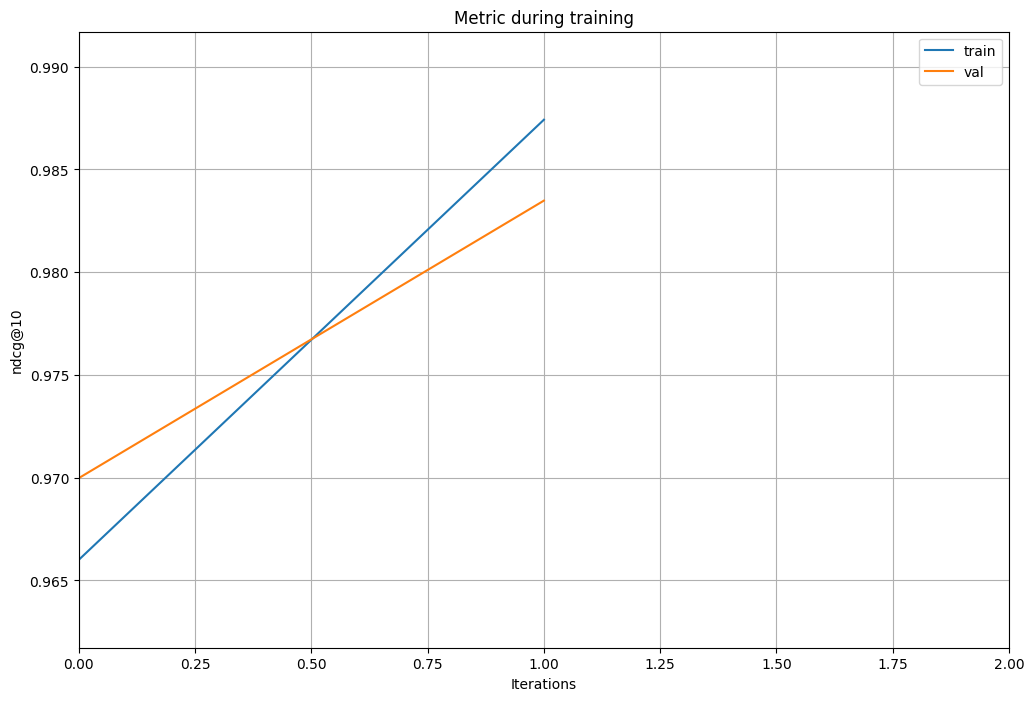

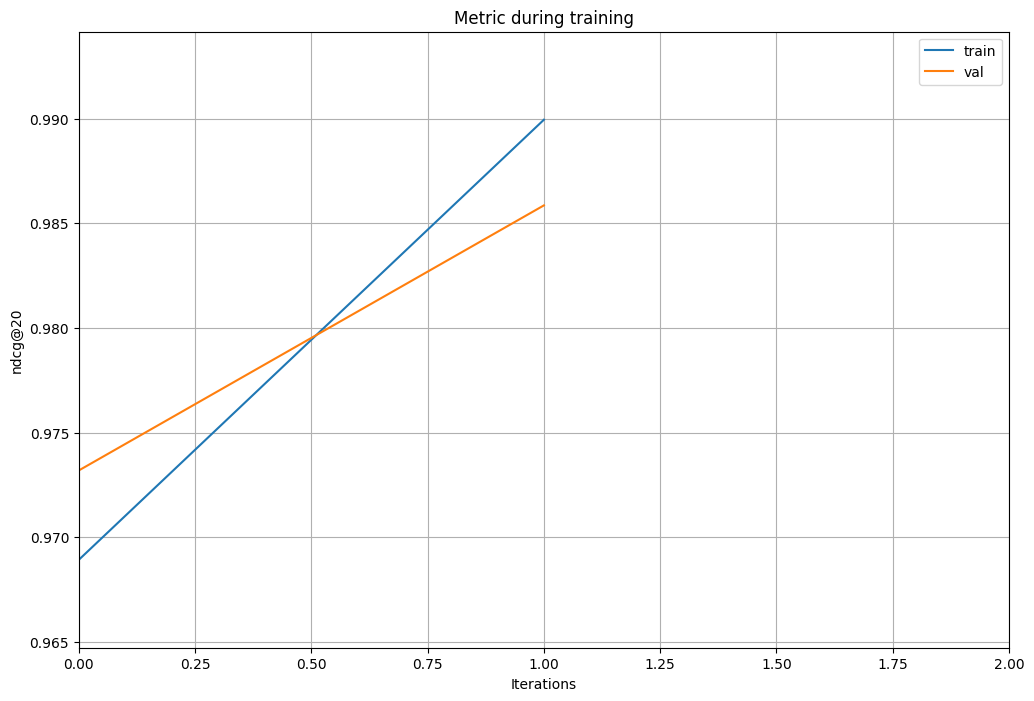

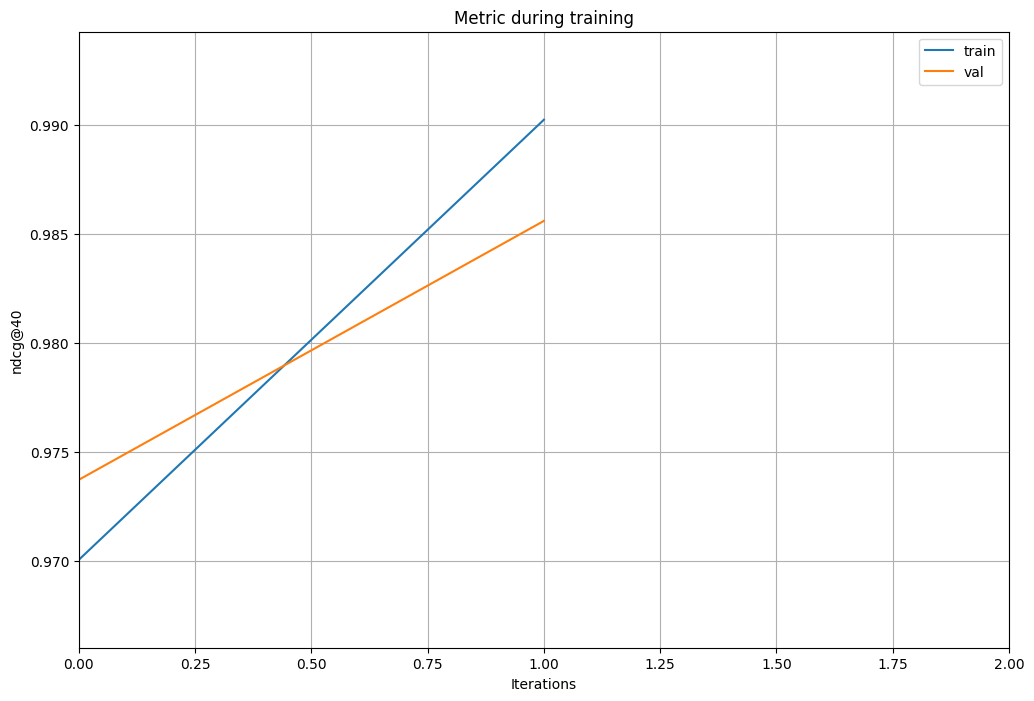

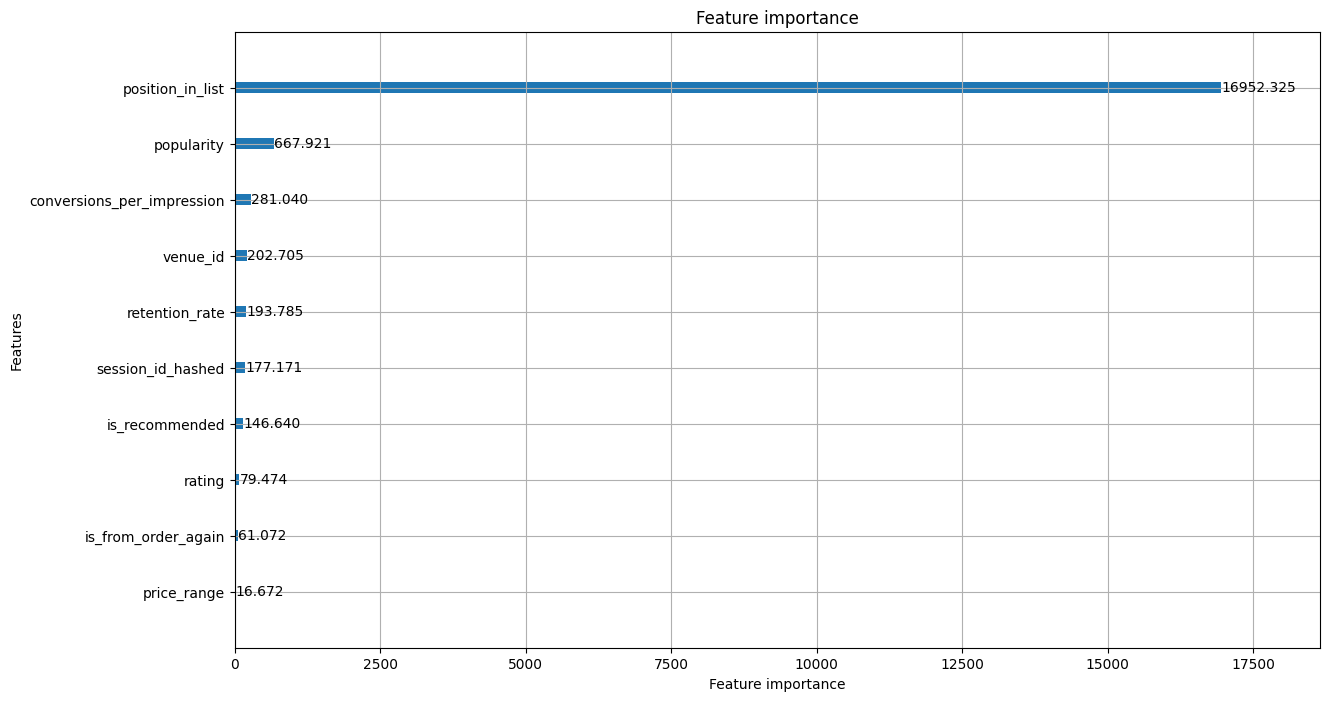

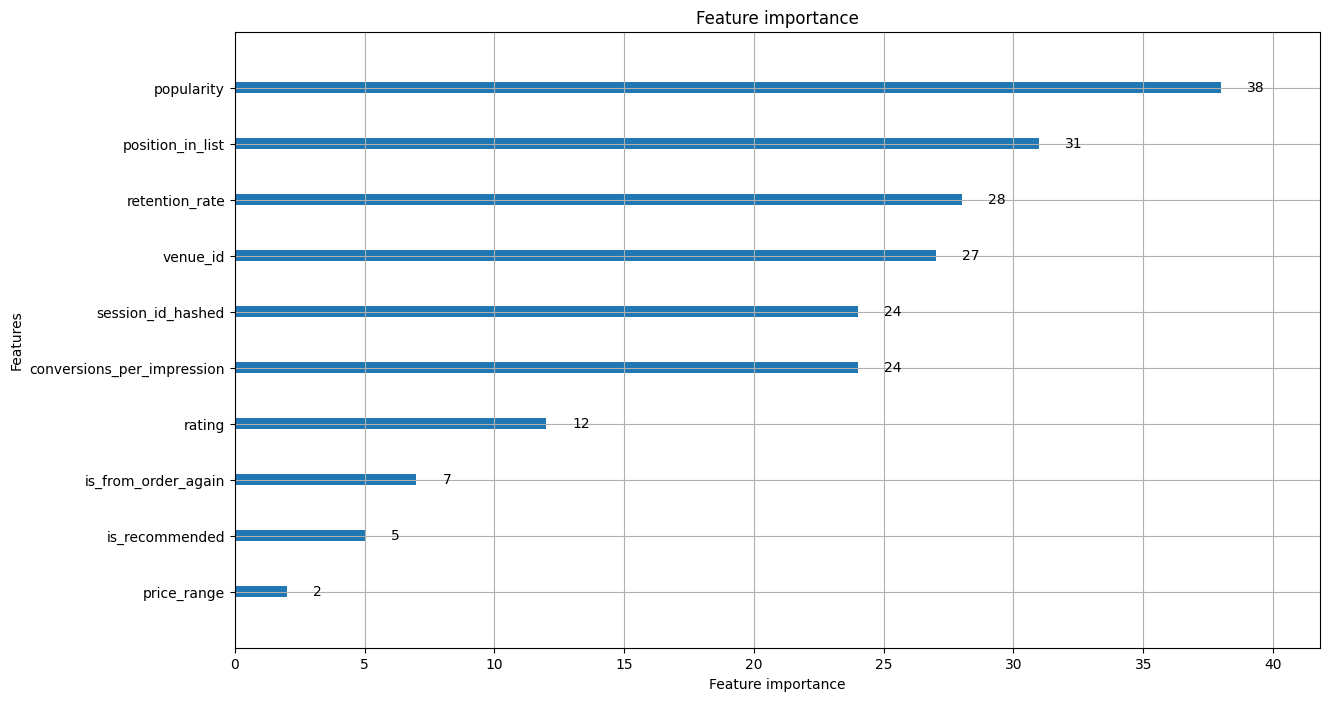

In [16]:
plot_lgb_report(lgb_model, evals_logs)

In [17]:
used_features = qa_features(lgb_model, features)

{'venue_id': 27, 'conversions_per_impression': 24, 'price_range': 2, 'rating': 12, 'popularity': 38, 'retention_rate': 28, 'session_id_hashed': 24, 'position_in_list': 31, 'is_from_order_again': 7, 'is_recommended': 5}
-------------------------------------------------------
Used features: 
['venue_id', 'conversions_per_impression', 'price_range', 'rating', 'popularity', 'retention_rate', 'session_id_hashed', 'position_in_list', 'is_from_order_again', 'is_recommended']
-------------------------------------------------------
passed 10 features and model used 10 of them
-------------------------------------------------------
these features were dropped: []


In [18]:
used_features

['venue_id',
 'conversions_per_impression',
 'price_range',
 'rating',
 'popularity',
 'retention_rate',
 'session_id_hashed',
 'position_in_list',
 'is_from_order_again',
 'is_recommended']

# save the trained model

In [19]:
%%time
lgb_model.save_model("/tmp/venues_ranking.pkl")

CPU times: user 4.53 ms, sys: 0 ns, total: 4.53 ms
Wall time: 3.15 ms


In [20]:
(
    ranking_data
    # .filter(pl.col("session_id_hashed")==2697534841382868)
    .sort(by=[group_column, rank_column], reverse=False)
    .groupby("session_id")
    .agg(
        pl.all().take([0,1, 2])
    )
    .explode("rating")
)

session_id,,purchased,position_in_list,venue_id,has_seen_venue_in_this_session,is_new_user,is_from_order_again,is_recommended,_right,conversions_per_impression,price_range,rating,popularity,retention_rate,session_id_hashed
str,list[i64],list[i8],list[i64],list[i64],list[i8],list[i8],list[i8],list[i8],list[i64],list[f64],list[i64],f64,list[f64],list[f64],list[u64]
"""93c5ce53-53b5-...","[3283618, 3283628, 3283660]","[0, 0, 0]","[213, 223, 255]","[8436895510884739671, 472199130850792437, 3257242292074930225]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[63, 250, 398]","[0.015707, 0.026087, 0.0]","[1, 1, 2]",9.0,"[0.0, 0.0, 0.0]","[0.214286, 1.0, 0.214286]","[11767530105295463493, 11767530105295463493, 11767530105295463493]"
"""93c5ce53-53b5-...","[3283618, 3283628, 3283660]","[0, 0, 0]","[213, 223, 255]","[8436895510884739671, 472199130850792437, 3257242292074930225]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[63, 250, 398]","[0.015707, 0.026087, 0.0]","[1, 1, 2]",9.0,"[0.0, 0.0, 0.0]","[0.214286, 1.0, 0.214286]","[11767530105295463493, 11767530105295463493, 11767530105295463493]"
"""93c5ce53-53b5-...","[3283618, 3283628, 3283660]","[0, 0, 0]","[213, 223, 255]","[8436895510884739671, 472199130850792437, 3257242292074930225]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[63, 250, 398]","[0.015707, 0.026087, 0.0]","[1, 1, 2]",8.8,"[0.0, 0.0, 0.0]","[0.214286, 1.0, 0.214286]","[11767530105295463493, 11767530105295463493, 11767530105295463493]"
"""24DFF2A9-F552-...","[823267, 823305, 823268]","[0, 0, 0]","[6, 44, 7]","[-5395232461768807165, 3828513221930446054, 1606463912219618573]","[1, 0, 1]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[744, 788, 746]","[0.040307, 0.096154, 0.074689]","[2, 2, 2]",8.0,"[0.037183, 0.083844, 0.105013]","[0.1304355, 0.0, 0.0]","[12188975462137121799, 12188975462137121799, 12188975462137121799]"
"""24DFF2A9-F552-...","[823267, 823305, 823268]","[0, 0, 0]","[6, 44, 7]","[-5395232461768807165, 3828513221930446054, 1606463912219618573]","[1, 0, 1]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[744, 788, 746]","[0.040307, 0.096154, 0.074689]","[2, 2, 2]",7.8,"[0.037183, 0.083844, 0.105013]","[0.1304355, 0.0, 0.0]","[12188975462137121799, 12188975462137121799, 12188975462137121799]"
"""24DFF2A9-F552-...","[823267, 823305, 823268]","[0, 0, 0]","[6, 44, 7]","[-5395232461768807165, 3828513221930446054, 1606463912219618573]","[1, 0, 1]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[744, 788, 746]","[0.040307, 0.096154, 0.074689]","[2, 2, 2]",7.4,"[0.037183, 0.083844, 0.105013]","[0.1304355, 0.0, 0.0]","[12188975462137121799, 12188975462137121799, 12188975462137121799]"
"""59E3BA4B-A116-...","[15515121, 15515181, 15515189]","[0, 0, 0]","[38, 98, 106]","[5976932403723417814, 3257242292074930225, 6994327881557323832]","[0, 0, 0]","[0, 0, 0]","[0, 0, 1]","[0, 0, 0]","[729, 398, 726]","[0.05632, 0.0, 0.052632]","[2, 2, 1]",9.0,"[0.0, 0.0, 0.0]","[0.321429, 0.214286, 0.0]","[1443199605474326762, 1443199605474326762, 1443199605474326762]"
"""59E3BA4B-A116-...","[15515121, 15515181, 15515189]","[0, 0, 0]","[38, 98, 106]","[5976932403723417814, 3257242292074930225, 6994327881557323832]","[0, 0, 0]","[0, 0, 0]","[0, 0, 1]","[0, 0, 0]","[729, 398, 726]","[0.05632, 0.0, 0.052632]","[2, 2, 1]",8.8,"[0.0, 0.0, 0.0]","[0.321429, 0.214286, 0.0]","[1443199605474326762, 1443199605474326762, 1443199605474326762]"
"""59E3BA4B-A116-...","[15515121, 15515181, 15515189]","[0, 0, 0]","[38, 98, 106]","[5976932403723417814, 3257242292074930225, 6994327881557323832]","[0, 0, 0]","[0, 0, 0]","[0, 0, 1]","[0, 0, 0]","[729, 398, 726]","[0.05632, 0.0, 0.052632]","[2, 2, 1]",9.0,"[0.0, 0.0, 0.0]","[0.321429, 0.214286, 0.0]","[1443199605474326762, 1443199605474326762, 1443199605474326762]"


In [21]:
def calculate_ndcg_score(y_true: pl.Series, y_pred:pl.Series):
    return pl.Series([ndcg_score(y_true=y_true, y_score=y_pred)], dtype=pl.Float64)

In [22]:
predictions = generate_predictions(test_set, lgb_model, features_to_use=features)
predictions_pl = pl.DataFrame(predictions)

In [23]:
predictions_pl

column_0,purchased,session_id,position_in_list,venue_id,has_seen_venue_in_this_session,is_new_user,is_from_order_again,is_recommended,_right,conversions_per_impression,price_range,rating,popularity,retention_rate,session_id_hashed,pred_has_seen_venue_in_this_session,predicted_popularity
i64,i8,str,i64,i64,i8,i8,i8,i8,i64,f64,i64,f64,f64,f64,u64,f64,i64
12099563,0,"""D9D4977A-97A9-...",109,-1012604272228201392,0,0,0,0,733,0.019934,2,8.6,0.0,0.333333,2697534841382868,-2.013172,94
12099587,0,"""D9D4977A-97A9-...",133,-9076052207444688139,0,0,1,0,409,0.0,2,8.6,0.0,0.0,2697534841382868,-2.013172,95
12099529,0,"""D9D4977A-97A9-...",75,5976932403723417814,0,0,0,0,729,0.05632,2,9.0,0.0,0.321429,2697534841382868,-1.257192,50
12099626,0,"""D9D4977A-97A9-...",172,8555011602643323738,0,0,0,0,517,0.084507,2,8.6,0.039362,0.6,2697534841382868,-2.268694,99
12099579,0,"""D9D4977A-97A9-...",125,-6330277521794443126,0,0,0,0,296,0.092308,2,8.6,0.146844,0.375,2697534841382868,-1.864834,91
12099619,0,"""D9D4977A-97A9-...",165,2038091771817113917,0,0,0,0,512,0.089641,1,9.4,0.189764,0.423076,2697534841382868,-2.268694,100
12099583,0,"""D9D4977A-97A9-...",129,6904207799526416654,0,0,0,0,344,0.070866,2,8.0,0.190418,0.181035,2697534841382868,-1.864834,92
12099576,0,"""D9D4977A-97A9-...",122,4942885110225136931,0,0,0,0,202,0.14941,2,8.6,0.249897,0.068183,2697534841382868,-1.864834,93
12099531,0,"""D9D4977A-97A9-...",77,-1249386614889987096,0,0,0,0,441,0.146789,2,9.4,0.293107,0.294117,2697534841382868,-1.757701,83


In [24]:
"has_seen_venue_in_this_session"

'has_seen_venue_in_this_session'

In [25]:
def drop_sessions_with_no_interactions(ranking_data):
    active_sessions = (
        ranking_data
        .filter(pl.col(label_column)==1)
        .select("session_id","position_in_list", "popularity").sort("session_id").groupby("session_id").count().sort("count")\
        .filter(pl.col("count")>1).select("session_id")
    )
    active_ranking_data = ranking_data.join(active_sessions, on="session_id")

    return active_ranking_data

In [26]:
active_ranking_data = drop_sessions_with_no_interactions(predictions_pl)

In [27]:
import numpy as np
import numpy as np
from sklearn.metrics import ndcg_score

def my_ndcg(y_true, y_pred):
    y_true = np.asarray([y_true])
    y_pred = np.asarray([y_pred])
    return ndcg_score(y_true=y_true, y_score = y_pred)

In [28]:
%%time
baseline_ndcg_per_sessions = (
    active_ranking_data
    .filter(pl.col(label_column)==1)
    .groupby("session_id")
    .agg([
        pl.apply(
            [pl.col('position_in_list'), pl.col("popularity")], lambda s: my_ndcg(s[0],s[1]) ).alias('baseline_ndcg')
    ])
)

CPU times: user 846 ms, sys: 0 ns, total: 846 ms
Wall time: 825 ms


In [29]:
predictions_pl.columns

['column_0',
 'purchased',
 'session_id',
 'position_in_list',
 'venue_id',
 'has_seen_venue_in_this_session',
 'is_new_user',
 'is_from_order_again',
 'is_recommended',
 '_right',
 'conversions_per_impression',
 'price_range',
 'rating',
 'popularity',
 'retention_rate',
 'session_id_hashed',
 'pred_has_seen_venue_in_this_session',
 'predicted_popularity']

In [30]:
%%time
model_ndcg_per_sessions = (
    active_ranking_data
    .filter(pl.col(label_column)==1)
    .groupby("session_id")
    .agg([
        pl.apply(
            [pl.col('position_in_list'), pl.col("predicted_popularity")], lambda s: my_ndcg(s[0],s[1]) ).alias('model_ndcg')
    ])
)

CPU times: user 865 ms, sys: 0 ns, total: 865 ms
Wall time: 851 ms


In [31]:
metric_columns = ["baseline_ndcg", "model_ndcg"]

In [32]:
predictions_pl.join(baseline_ndcg_per_sessions, on="session_id").join(model_ndcg_per_sessions, on="session_id")[ used_features + metric_columns].with_columns(
    [
        (pl.col("model_ndcg")-pl.col("baseline_ndcg")).alias("ndcg_diff")
    ]
).groupby("venue_id").mean()

venue_id,conversions_per_impression,price_range,rating,popularity,retention_rate,session_id_hashed,position_in_list,is_from_order_again,is_recommended,baseline_ndcg,model_ndcg,ndcg_diff
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
8739452560446927232,0.369035,2.0,9.2,1.543607,0.211656,9.1195e18,266.631304,0.013043,0.021739,0.80315,0.942469,0.139318
-692123557610643528,0.312303,1.0,8.6,7.88356,0.339817,8.5751e18,66.542169,0.084337,0.012048,0.871096,0.941968,0.070871
-8977370070919451504,0.107749,2.0,8.6,10.176772,0.29593,8.9857e18,228.402469,0.139506,0.018519,0.811389,0.941878,0.130489
6994327881557323832,0.052632,1.0,9.0,0.0,0.0,9.2529e18,144.934021,0.278351,0.02268,0.841273,0.938664,0.097391
4296932382152124576,0.143236,2.0,9.2,3.611698,0.281934,9.1772e18,132.025116,0.046512,0.028837,0.800664,0.940166,0.139503
8857820397515963904,0.078671,2.0,7.6,0.190774,0.288462,9.0095e18,268.353105,0.00278,0.021316,0.803413,0.941359,0.137946
-8406435654769921472,0.0,2.0,9.0,0.0,0.0,8.7582e18,252.515152,0.084175,0.016835,0.808235,0.938864,0.130628
-1524778585215246056,0.034932,2.0,8.4,9.414863,0.183824,8.2551e18,109.22619,0.0,0.047619,0.866103,0.941854,0.075752
4406865192044003216,0.104159,2.0,9.0,9.040655,0.404378,8.6883e18,46.304348,0.152174,0.021739,0.870146,0.965899,0.095752
